## CSE473: Lab Experiment \#07 - AutoEncoders

### Lab Objectives

This lab explores Autoencoders, an unsupervised learning algorithm. The primary objectives are:

  * Learn the structure of **autoencoders** as a feature extractor.
  * Implement an autoencoder using **TensorFlow**.
  * Implement a **denoising network** using autoencoders.

-----

##  Part 1: Autoencoders and Architecture Overview

An **Autoencoder** is an unsupervised learning neural network that learns to reconstruct the features of a dataset. It's used for **dimensionality reduction** and **feature extraction**.

Its structure consists of two main parts:

1.  **Encoder**: Receives the input features and passes them through hidden layers to create an **internal representation (coding)**.
2.  **Decoder**: Uses the learned coding to reconstruct the output.

A constraint is placed on the encoders (e.g., reducing the input dimension) to force the network to learn an efficient representation, preventing trivial memorization. Autoencoders with restricted Encoders and Decoders are called **undercomplete**.

### Stacked Autoencoders

A **Stacked Autoencoder** enhances the simple architecture with **multiple hidden layers**. These layers allow the network to learn more complex patterns. The hidden layers are typically added **symmetrically** to both the Encoder and Decoder parts.

-----
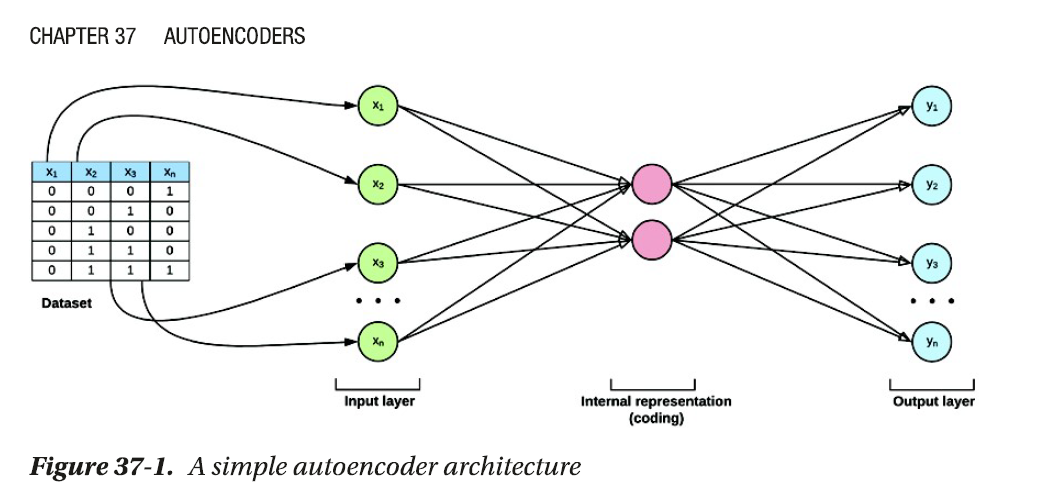
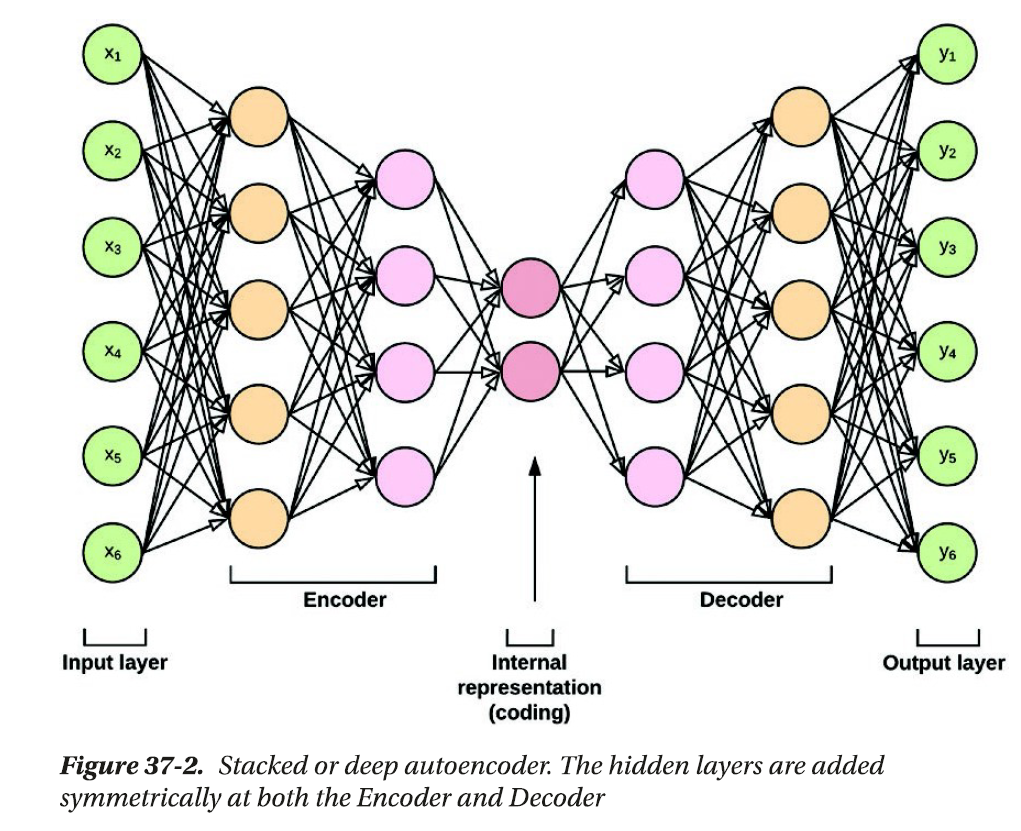

## Part 2: Stacked Autoencoder Implementation with TensorFlow

This section implements a stacked autoencoder using TensorFlow and the **MNIST handwriting dataset** to reconstruct the original images.

### 1\. Setup and Data Preprocessing

We'll import necessary packages, load the MNIST dataset, and preprocess the images by scaling and flattening them.

In [1]:
# import packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# import dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# change datatype to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# scale the dataset from 0->255 to 0->1
x_train /= 255
x_test /= 255

# flatten the 28x28 images into vectors of size 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 784)
Test data shape: (10000, 784)


### 2\. Define the Stacked Autoencoder Model

The model uses a symmetric architecture with three encoding layers (512, 128, 64 units) leading to a 32-unit coding layer, followed by three symmetric decoding layers (64, 128, 512 units).


In [2]:
# create the autoencoder model
def model_fn():
    model_input = tf.keras.layers.Input(shape=(784,))

    # Encoder part (decreasing number of units)
    encoded = tf.keras.layers.Dense(units=512, activation='relu')(model_input)
    encoded = tf.keras.layers.Dense(units=128, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(units=64, activation='relu')(encoded)
    coding_layer = tf.keras.layers.Dense(units=32)(encoded) # Internal representation

    # Decoder part (increasing number of units, symmetric to encoder)
    decoded = tf.keras.layers.Dense(units=64, activation='relu')(coding_layer)
    decoded = tf.keras.layers.Dense(units=128, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(units=512, activation='relu')(decoded)
    decoded_output = tf.keras.layers.Dense(units=784)(decoded) # Output layer

    # the autoencoder model
    autoencoder_model = tf.keras.Model(inputs=model_input, outputs=decoded_output)

    # compile the model
    autoencoder_model.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
    return autoencoder_model

# build the model
autoencoder_model = model_fn()

# print autoencoder model summary
autoencoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 956,592 (3.65 MB)

 Trainable params: 956,592 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

### 3\. Training the Model

The model is trained to reconstruct its own input. The **reconstruction error** is used to evaluate how well the output matches the input.

In [3]:
# train the model
# Using a reduced number of epochs for demonstration (original was 1000)
autoencoder_model.fit(x_train, x_train,
                      epochs=100, # Reduced for time/resource
                      batch_size=256,
                      shuffle=True,
                      validation_data=(x_test, x_test))

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0068 - loss: 0.5311 - val_accuracy: 0.0113 - val_loss: 0.3612
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0103 - loss: 0.3484 - val_accuracy: 0.0112 - val_loss: 0.3159
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0122 - loss: 0.3112 - val_accuracy: 0.0088 - val_loss: 0.2874
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0104 - loss: 0.2933 - val_accuracy: 0.0095 - val_loss: 0.3195
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0103 - loss: 0.3009 - val_accuracy: 0.0125 - val_loss: 0.2618
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0106 - loss: 0.2804 - val_accuracy: 0.0066 - val_loss: 0.2947
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0104 - loss: 0.2879 - val_accuracy: 0.0033 - val_loss: 0.3123
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0097 - loss: 0.3025 - val_acc

### 4\. Visualize Reconstruction

We'll use the trained model to reconstruct test images and visualize the results, contrasting the original image with the autoencoder's output.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


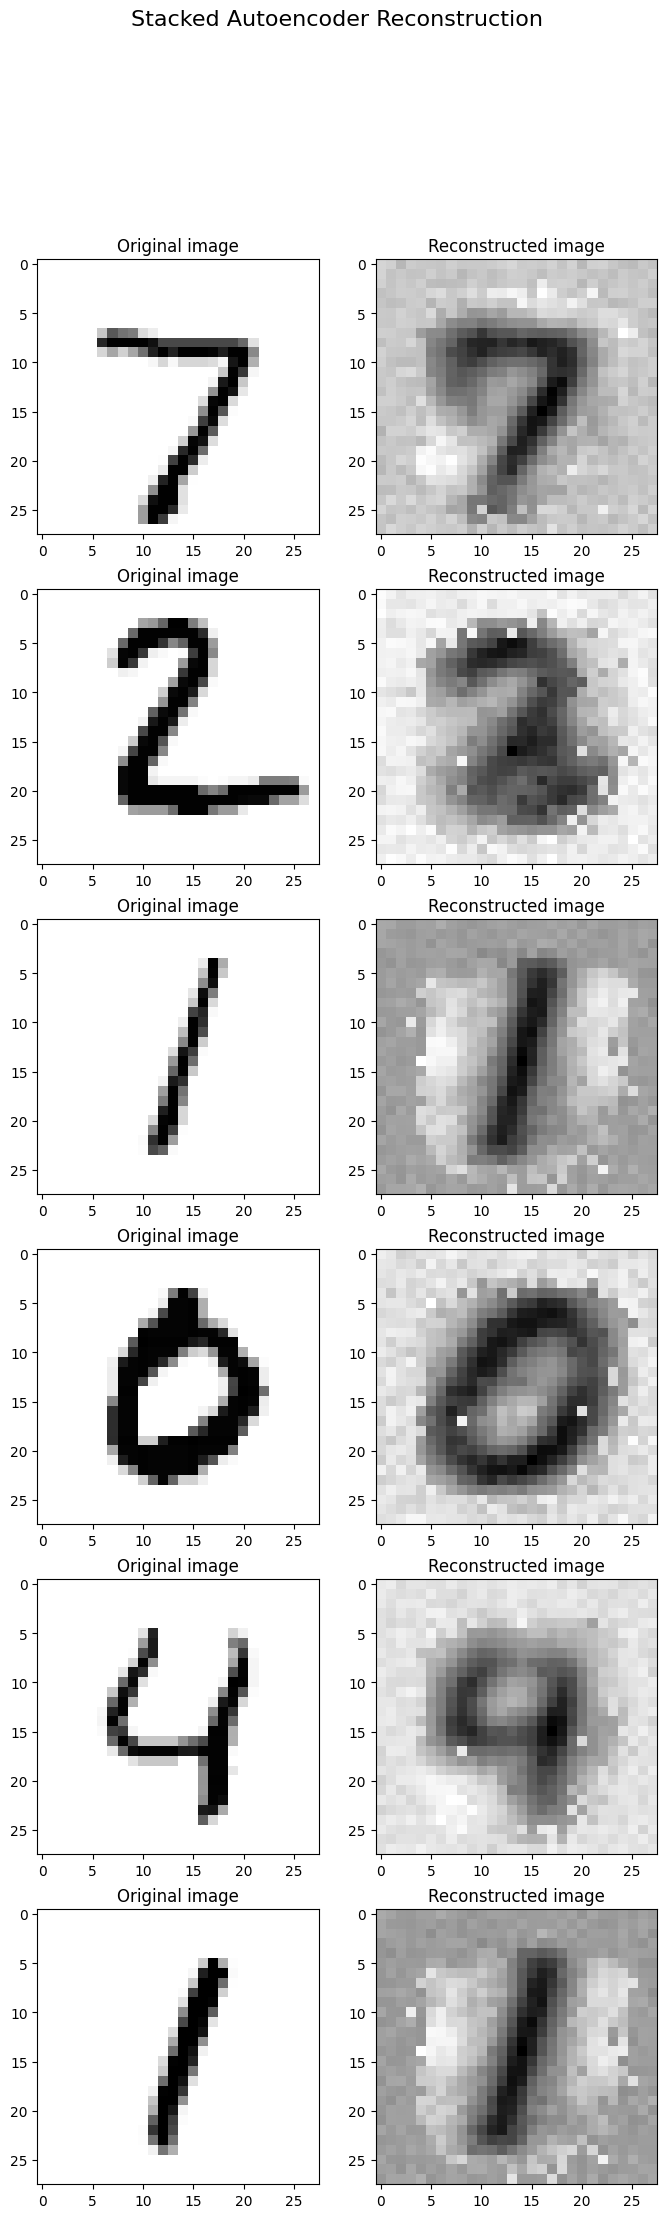

In [4]:
# visualize reconstruction
sample_size = 6
test_image = x_test[:sample_size]

# reconstruct test samples
test_reconstruction = autoencoder_model.predict(test_image)

plt.figure(figsize=(8, 25))
plt.suptitle('Stacked Autoencoder Reconstruction', fontsize=16)

for i in range(sample_size):
    # Original image
    plt.subplot(sample_size, 2, i*2 + 1)
    plt.title('Original image')
    plt.imshow(test_image[i].reshape((28, 28)), cmap="Greys",
               interpolation="nearest", aspect='auto')

    # Reconstructed image
    plt.subplot(sample_size, 2, i*2 + 2)
    plt.title('Reconstructed image')
    plt.imshow(test_reconstruction[i].reshape((28, 28)), cmap="Greys",
               interpolation="nearest", aspect='auto')

plt.show()

-----

## Part 3: Denoising Autoencoders

**Denoising Autoencoders** are a variant that adds a different constraint to the network to prevent memorization.

The constraint is applied by **imputing some Gaussian noise** into the inputs or by **randomly deactivating some input neurons** (similar to Dropout). This forces the autoencoder to learn the **uncorrupted form** of the input features.

Denoising autoencoders typically use an **overcomplete network architecture**, meaning the dimensions of the hidden Encoder and Decoder layers are **not restricted** to be less than the input layer.



Modifying the Code for a Denoising Autoencoder

To convert the Stacked Autoencoder (Part 2) into a Denoising Autoencoder, you need to implement the core constraint: **adding noise to the training data** while keeping the goal as reconstructing the original, uncorrupted data.

Here are the specific modifications to the Python code:

### 1\. Architectural Change (Optional but Recommended)
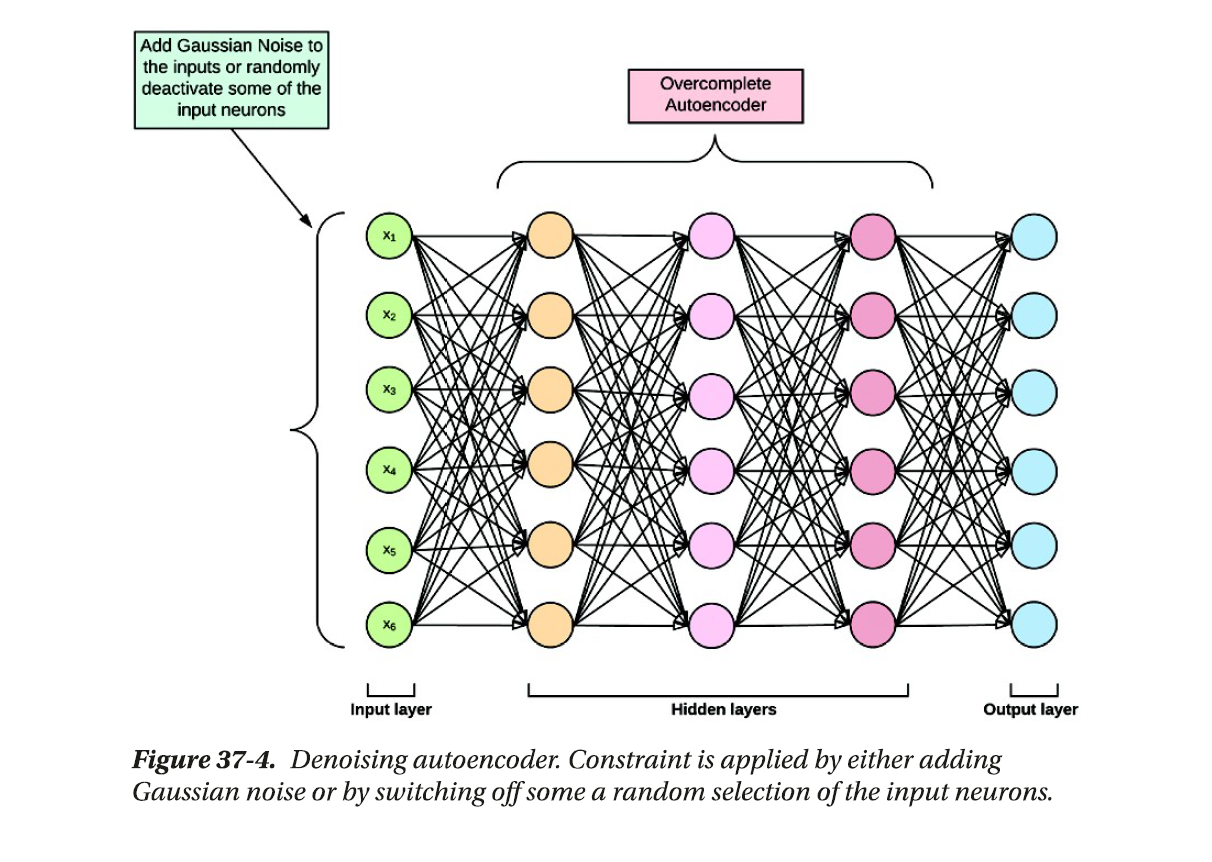

Denoising autoencoders often use an **overcomplete** architecture, meaning the layers don't necessarily decrease to a bottleneck. Since the purpose of the lab is to implement a denoising network, you could keep the structure the same but understand it's the *noise* constraint, not the layer size, that defines the denoising capability.

### 2\. Data Preparation: Adding Noise

Before training, create a noisy version of your training data (`x_train_noisy`). You can use TensorFlow's layers to easily add Gaussian noise.

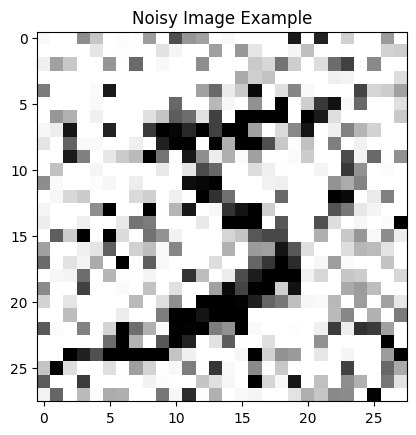

In [5]:
# --- MODIFICATION 1: Create Noisy Data ---

# Define the noise factor (hyperparameter)
noise_factor = 0.5

# Add random noise to the training and test images
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to ensure they remain in the [0, 1] range after adding noise
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Visualize a noisy image (optional)
plt.imshow(x_train_noisy[0].reshape((28, 28)), cmap="Greys")
plt.title('Noisy Image Example')
plt.show()

### 3\. Training: Input Noisy, Output Clean

The key change is in the `.fit()` call. You must train the model to map the **noisy input** (`x_train_noisy`) to the **clean output** (`x_train`).

In [6]:
# --- MODIFICATION 2: Change Training Call ---

# Build the model (using the same model_fn() from Part 2)
denoising_autoencoder_model = model_fn()

# Train the model: Input is noisy data, expected output is the original, clean data
denoising_autoencoder_model.fit(x_train_noisy, # Input: Noisy
                                x_train,       # Target: Clean
                                epochs=100,
                                batch_size=256,
                                shuffle=True,
                                validation_data=(x_test_noisy, x_test))

# The model learns to remove the noise introduced in x_train_noisy to reconstruct x_train.

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.0065 - loss: 0.5165 - val_accuracy: 0.0129 - val_loss: 0.3427
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0107 - loss: 0.3355 - val_accuracy: 0.0043 - val_loss: 0.3175
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0080 - loss: 0.3100 - val_accuracy: 0.0095 - val_loss: 0.2697
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0087 - loss: 0.2682 - val_accuracy: 0.0107 - val_loss: 0.2590
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0076 - loss: 0.2828 - val_accuracy: 0.0073 - val_loss: 0.2877
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0065 - loss: 0.2817 - val_accuracy: 0.0074 - val_loss: 0.2694
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0070 - loss: 0.3038 - val_accuracy: 0.0063 - val_loss: 0.2623
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0083 - loss: 0.3003 - val_acc

### 4\. Visualization: Testing with Noisy Images

For the prediction and visualization steps, you should use the noisy test set as input to see how well the model denoises the images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


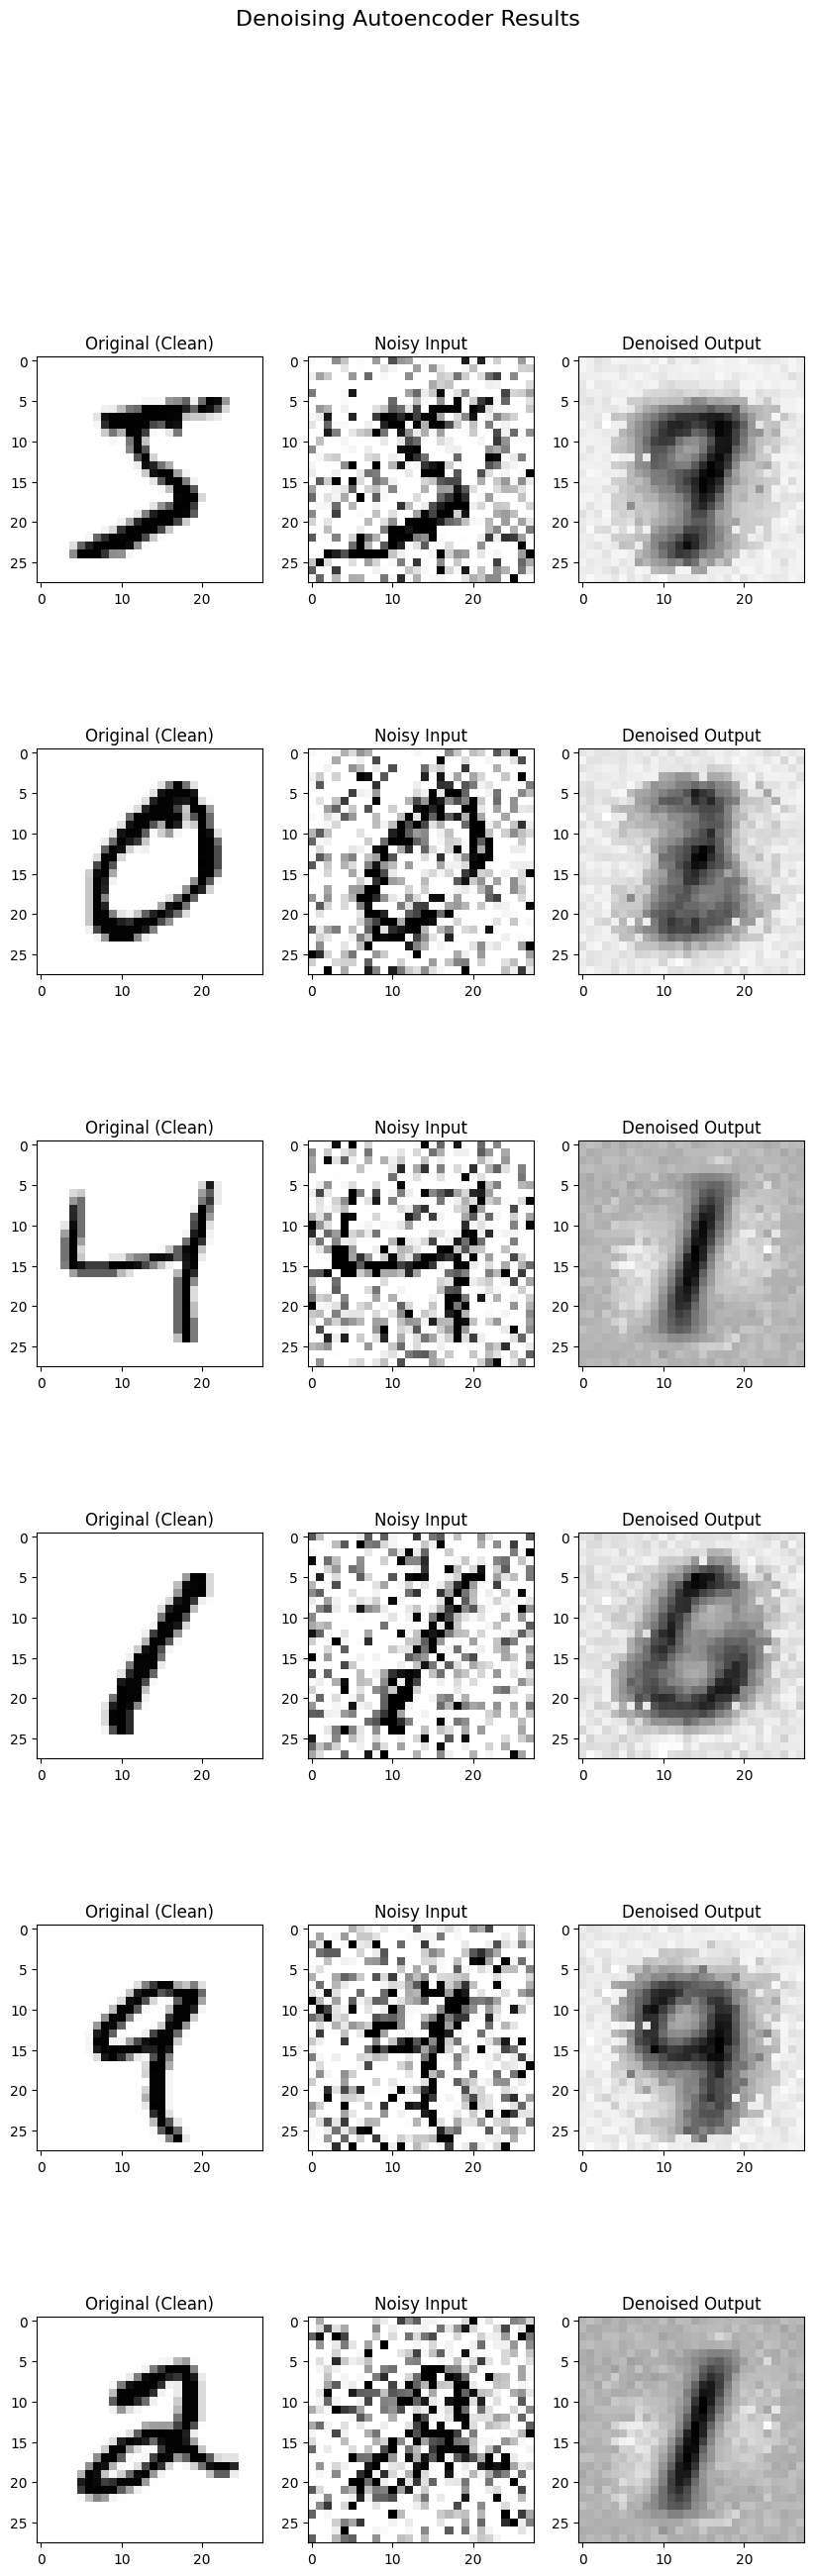

In [7]:
# --- MODIFICATION 3: Change Prediction Input ---

# Use the noisy test set for prediction
test_reconstruction = denoising_autoencoder_model.predict(x_test_noisy[:sample_size])

plt.figure(figsize=(10, 30))
plt.suptitle('Denoising Autoencoder Results', fontsize=16)

for i in range(sample_size):
    # Original (Clean) image
    plt.subplot(sample_size, 3, i*3 + 1)
    plt.title('Original (Clean)')
    plt.imshow(x_train[i].reshape ((28, 28)), cmap="Greys")

    # Noisy input image
    plt.subplot(sample_size, 3, i*3 + 2)
    plt.title('Noisy Input')
    plt.imshow(x_train_noisy[i].reshape ((28, 28)), cmap="Greys")

    # Reconstructed image (Denoised Output)
    plt.subplot(sample_size, 3, i*3 + 3)
    plt.title('Denoised Output')
    plt.imshow(test_reconstruction[i].reshape((28, 28)), cmap="Greys")

plt.show()